# Import Libraries

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Data Loading and Editing

In [2]:
df = pd.read_csv('../input/insurance/insurance.csv')

In [3]:
# Basic statistical details

df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
#Missing data check

df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.dtypes 

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
# Removing duplicate rows.

print('Duplicate Rows Count : ', df.duplicated().sum())

df=df.drop_duplicates(keep="first")

Duplicate Rows Count :  1


<AxesSubplot:>

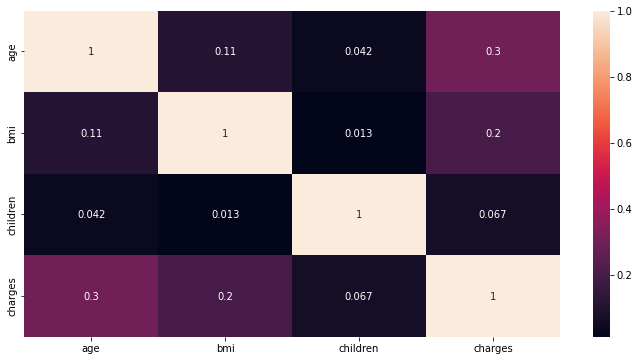

In [7]:
# Correlation Heatmap

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Editing Categorical Data

In [9]:
def encoder(method, dataframe, columns_label, columns_onehot):
    
    if method == 'labelEncoder':      
    
        df_lbl = dataframe.copy()
    
        for col in columns_label:
            label = LabelEncoder()
            label.fit(list(dataframe[col].values))
            df_lbl[col] = label.transform(df_lbl[col].values)
        
        return df_lbl
    
    elif method == 'oneHotEncoder':
        
        df_oh = dataframe.copy()

        df_oh= pd.get_dummies(data = df_oh, prefix = 'ohe', prefix_sep='_',
                       columns = columns_onehot,
                       drop_first =True,
                       dtype='int8')
        
        return df_oh

In [10]:
method =['labelEncoder', 'oneHotEncoder']
dataframe = df.copy()
columns_label = ['sex', 'smoker', 'region']
columns_onehot = ['sex', 'smoker', 'region', 'children']

df_label = encoder(method[0], dataframe, columns_label, columns_onehot)

df_onehot = encoder(method[1], dataframe, columns_label, columns_onehot)

df_label.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [11]:
df_onehot.head()

,age,bmi,charges,ohe_male,ohe_yes,ohe_northwest,ohe_southeast,ohe_southwest,ohe_1,ohe_2,ohe_3,ohe_4,ohe_5
0,19,27.900,16884.92400,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.55230,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.47061,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.85520,1,0,1,0,0,0,0,0,0,0


# Scaling data

In [12]:
def scaler(method, data, columns_scaler):
    
    if method == 'standartScaler':
        
        Standart = StandardScaler()

        df_standart = data.copy()

        df_standart[columns_scaler]=Standart.fit_transform(df_standart[columns_scaler])
        
        return df_standart
        
    elif method == 'minMaxScaler':
        
        MinMax= MinMaxScaler()

        df_minmax = data.copy()

        df_minmax[columns_scaler]=MinMax.fit_transform(df_minmax[columns_scaler])
        
        return df_minmax
    
    elif method =='npLog':
        
        df_nplog = data.copy()

        df_nplog[columns_scaler]=np.log(df_nplog[columns_scaler])
        
        return df_nplog
    
    elif method == 'default':
        
        return data

In [13]:
method = 'minMaxScaler'
data = df_label
columns_scaler = ['bmi', 'charges']

df_scaler = scaler(method, data, columns_scaler)

In [14]:
df_scaler.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,0.321227,0,1,3,0.251611
1,18,1,0.479150,1,0,2,0.009636
2,28,1,0.458434,3,0,2,0.053115
3,33,1,0.181464,0,0,1,0.333010
4,32,1,0.347592,0,0,1,0.043816


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Training and Prediction Without Hyperparameter Tuning

In [16]:
X = df_scaler.drop('charges',axis=1)
y = df_scaler['charges']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=16)

In [17]:
RandomForestRegressor=RandomForestRegressor(random_state = 42)

RandomForestRegressor.fit(X_train, y_train)

train_pred = RandomForestRegressor.predict(X_train)
test_pred = RandomForestRegressor.predict(X_test)

print('Train MAE :', mean_absolute_error(y_train,train_pred))

print('Test MAE :', mean_absolute_error(y_test, test_pred))

print('Train R2 :', r2_score(y_train,train_pred))

print('Test R2 :', r2_score(y_test, test_pred))

Train MAE : 0.015380042502886937
Test MAE : 0.042541620251306776
Train R2 : 0.9761169982562852
Test R2 : 0.8369807321937276


# Hyperparameter Tuning

In [18]:
def regression_gridsearch(param_grid_data, model_params, func_input):
    last=[]
    model_params=model_params
    for params in param_grid_data:
        
        result = {}
        result['encoder'] = params['encoder']
        result['scaler'] = params['scaler']
        result['random_state'] = params['random_state']
        result['test_size'] = params['test_size']
        
        data = encoder(params['encoder'], func_input['data'], func_input['columns_label'], func_input['columns_onehot'] )
        data = scaler(params['scaler'], data,func_input['columns_scaler'])
        
        
        X = data.drop(func_input['output'],axis=1)
        y = data[func_input['output']].values.reshape(-1,)
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=params['test_size'],random_state=params['random_state'])      
        
        for model_name, mp in model_params.items():
            res={}
            res=result
            clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            test_score = r2_score(y_test, pred)
            test_mape = mean_absolute_percentage_error(y_test, pred)
            res['model']=model_name
            res['best_score']=clf.best_score_
            res['test_score']=test_score
            res['test_mape']=test_mape
            res['best_params']=clf.best_params_     
            last.append(res)
    result = pd.DataFrame(last, columns=['encoder','scaler','random_state','test_size','model','best_score','test_score','test_mape','best_params'])
    
    return result 

Bootstrap : Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

Max_Depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

Min_Samples_Leaf : The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

Min_Samples_Split : The minimum number of samples required to split an internal node.

N_Estimators : The number of trees in the forest.

Random_State : Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features). 


In [19]:
from sklearn.ensemble import RandomForestRegressor

param_grid_data = { 
    'encoder' : ['labelEncoder', 'oneHotEncoder'],
    'scaler' : ['standartScaler', 'minMaxScaler', 'npLog', 'default'],
    'random_state' : [16],
    'test_size' : [0.3]
}

param_grid_data = [dict(zip(param_grid_data.keys(), v)) for v in itertools.product(*param_grid_data.values())]

func_input = {
    'columns_label': ['sex', 'smoker', 'region'],
    'columns_onehot' : ['sex', 'smoker', 'region', 'children'],
    'columns_scaler' : ['bmi', 'charges'],
    'output' : ['charges'],
    'data' : df,
}

RandomForestRegressor_params = {
    'RFRegressor': {
    'model': RandomForestRegressor(),
    'params' : {'bootstrap': [True], # True, False
                'max_depth': [10, 20, 50], # 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None
                'max_features': ['auto','sqrt'], # 'auto','sqrt'
                'min_samples_leaf': [1, 2, 4], #1, 2, 4
                'min_samples_split': [2, 5], # 2, 5, 10
                'n_estimators': [100, 200],
                'random_state' : [42]}}, # 200, 400, 800, 1000, 1200
        }

In [20]:
RFR_result=regression_gridsearch(param_grid_data, RandomForestRegressor_params, func_input)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
RFR_result.head()

,encoder,scaler,random_state,test_size,model,best_score,test_score,test_mape,best_params
0,labelEncoder,standartScaler,16,0.3,RFRegressor,0.859100,0.852207,0.853929,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
1,labelEncoder,minMaxScaler,16,0.3,RFRegressor,0.859112,0.852170,inf,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
2,labelEncoder,npLog,16,0.3,RFRegressor,0.852468,0.798658,0.021884,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
3,labelEncoder,default,16,0.3,RFRegressor,0.859137,0.853895,0.245911,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
4,oneHotEncoder,standartScaler,16,0.3,RFRegressor,0.854013,0.850116,0.924765,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."


# Best Hyperparameter and Data Selection for The Model

In [22]:
def best_params(model_name, result):
    
    best_index =np.argmax(result['test_score'])

    best_params = result['best_params'][best_index]
    best_encoder = result['encoder'][best_index]
    best_scaler = result['scaler'][best_index]
    best_random_state = result['random_state'][best_index]
    best_test_size = result['test_size'][best_index]
    
    print('\nModel Name: ', model_name, '\nBest Params: ', best_params, '\nBest Encoder: ', best_encoder, '\nBest Scaler: ', best_scaler, '\nBest Random State: ', best_random_state, '\nBest Test Size: ', best_test_size)

    best_params = {
        'params' : best_params,
        'encoder' : best_encoder,
        'scaler' : best_scaler,
        'random_state' : best_random_state,
        'test_size' : best_test_size   
        }
    
    return best_params

In [23]:
best_params_rfr = best_params('Random Forest Regression', RFR_result)


Model Name:  Random Forest Regression 
Best Params:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42} 
Best Encoder:  labelEncoder 
Best Scaler:  default 
Best Random State:  16 
Best Test Size:  0.3


In [24]:
def best_data(best_params, func_input):

    data = encoder(best_params['encoder'], func_input['data'], func_input['columns_label'], func_input['columns_onehot'])
    data = scaler(best_params['scaler'], data, func_input['columns_scaler'])

    X = data.drop(func_input['output'],axis=1)
    y = data[func_input['output']].values.reshape(-1,)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=best_params['test_size'],random_state=best_params['random_state'])
    
    return X, y, X_train, X_test, y_train, y_test

# Training and Prediction with The Best Parameter

In [25]:
X, y, X_train, X_test, y_train, y_test = best_data(best_params_rfr, func_input)

RandomForestRegressor=RandomForestRegressor(bootstrap = best_params_rfr['params']['bootstrap'], max_depth = best_params_rfr['params']['max_depth'],
                                            max_features = best_params_rfr['params']['max_features'], min_samples_leaf = best_params_rfr['params']['min_samples_leaf'],
                                            min_samples_split = best_params_rfr['params']['min_samples_split'], n_estimators = best_params_rfr['params']['n_estimators'],
                                            )

RandomForestRegressor.fit(X_train, y_train)

train_pred = RandomForestRegressor.predict(X_train)
test_pred = RandomForestRegressor.predict(X_test)

print('Train MAE :', mean_absolute_error(y_train,train_pred))

print('Test MAE :', mean_absolute_error(y_test, test_pred))

print('Train R2 :', r2_score(y_train,train_pred))

print('Test R2 :', r2_score(y_test, test_pred))

Train MAE : 1770.893026342933
Test MAE : 2572.846551420561
Train R2 : 0.9187956321621771
Test R2 : 0.8541754885797586


# Comparison of Actual and Predicted Values

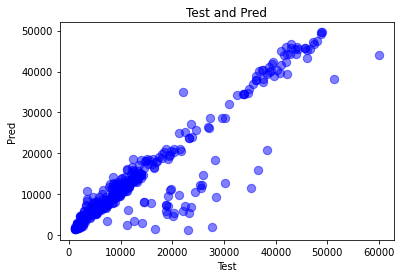

In [26]:
plt.scatter(x = y_test, y = test_pred, color = 'blue', marker = 'o', s = 70, alpha = 0.5,
          label = 'Test data')
plt.title('Test and Pred')
plt.xlabel('Test')
plt.ylabel('Pred')
plt.show()

# Source

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74